In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


In [6]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [7]:
images.shape

TensorShape([2, 70, 120, 3])

In [8]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [9]:
fmaps.shape

TensorShape([2, 64, 114, 32])

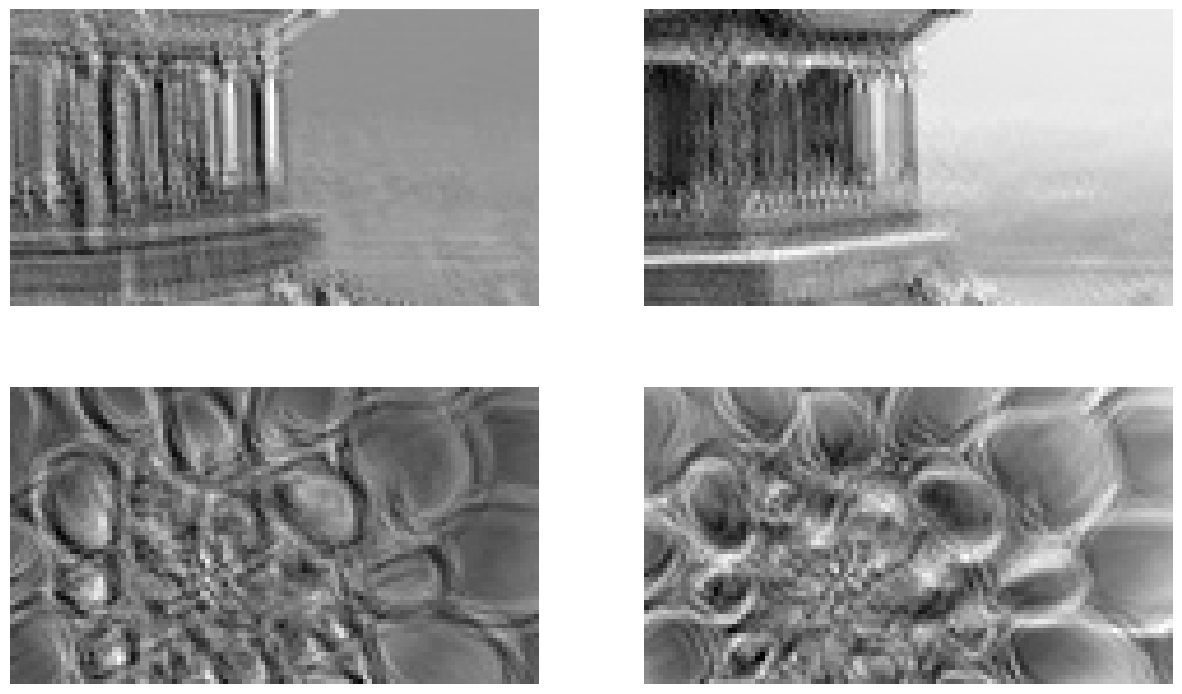

In [10]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [12]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [13]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [14]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [15]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [16]:
biases.shape

(32,)

In [17]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

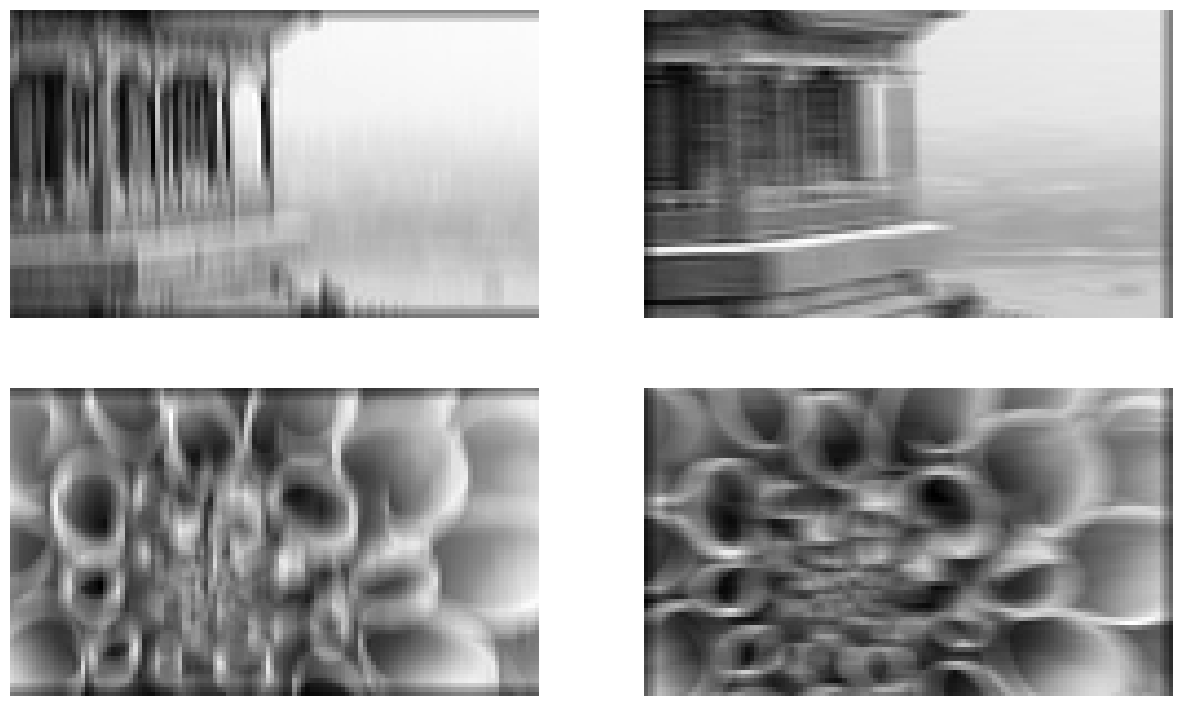

In [18]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [19]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [20]:
output = max_pool(images)

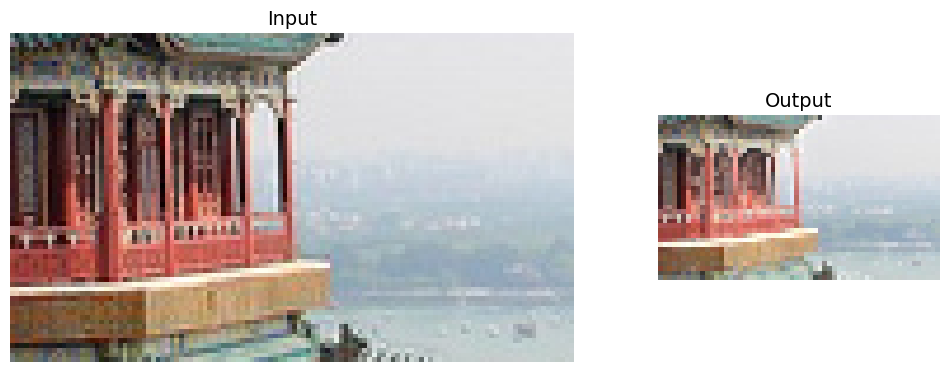

In [21]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [22]:
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [23]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [24]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

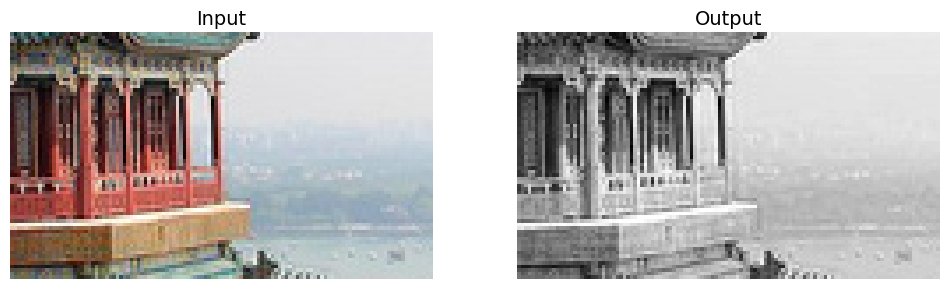

In [25]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

In [26]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [27]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [28]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>

In [29]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [30]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

C:\Users\tglee\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 252s 144ms/step - accuracy: 0.6216 - loss: 1.0948 - val_accuracy: 0.8680 - val_loss: 0.3672
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 288s 167ms/step - accuracy: 0.8514 - loss: 0.4434 - val_accuracy: 0.8916 - val_loss: 0.2982
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 336s 175ms/step - accuracy: 0.8781 - loss: 0.3583 - val_accuracy: 0.8860 - val_loss: 0.3149
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 583s 339ms/step - accuracy: 0.8919 - loss: 0.3247 - val_accuracy: 0.8986 - val_loss: 0.2855
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 516s 300ms/step - accuracy: 0.9027 - loss: 0.2853 - val_accuracy: 0.9068 - val_loss: 0.2780
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 451s 262ms/step - accuracy: 0.9092 - loss: 0.2652 - val_accuracy: 0.9080 - val_loss: 0.2751
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 483s 281ms/step - accuracy: 0.9130 - loss: 0.2552 - val_accuracy: 0.9058 - val_loss: 0.2686
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 311s 169ms/step - ac